 <b>Reference:</b> Radford, Alec et al. “Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks.” CoRR abs/1511.06434 (2016): n. pag.

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!


def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

### Dataset

The GAN is being trained on MNIST dataset to produce the hand-written digit images given a random noise. The **Generator** architecture upsamples the given noise vector using **ConvolutionTranspose** layer to reconstruct the desired image of specific dimensions. 

**Choice of HyperParameters**

* **Channel of Image:** 1 because the MNIST images are the binary images where the foreground is denoted by pixel value 1 and bachground by picel value 0 

* **No. of Hidden Layers:** **2**, because the dataset is relatively simple compared to complex visual data. I have decided to use two hidden layer which first increases the spatial dimensionality by factor of 4. The second layer reduces the spatial dimensions by half to preserve the relevant features from output from previous layer which is then passed through final convolutional layer to reonstruct the desired image of 64 x 64 x 1 dimensions.


* **Loss Function**: **Binary Cross-Entropy** as it suits well the structure of our problem where the task of the discriminator is to distinguish between fake or real images i.e. 0 or 1.


* **Optimizer**: Adam optimizer is being used as it is the optimal and common choice for most of the CNN based architectures.


* **Learning Rate:** The paper suggests the default learning rate 0.001 is way to high for training purposes which makes GAN more suspectible to instability. Therefore, the suggested learning rate of 0.0002 is the optimal option go with.


* **Activation Functions:** Following are the choice of activation function for the hidden leayers and output layers:

    - 'ReLU' for hidden leayer in case of generator to avoid the problem of vanishing gradients and expedite the learning of the model. However, the output layer makes use of 'tanh' to scale the output between the range of -1 and 1.
    
    - 'LeakyReLU' works well for the convolution layers in the discriminator with a slope of 0.2.

In [2]:
# Generator
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN, 
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''

        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels=input_channels, out_channels=output_channels, 
                                  kernel_size=kernel_size, stride=stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU()
            )
        else: # Final Layer
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels=input_channels, out_channels=output_channels, 
                                  kernel_size=kernel_size, stride=stride),
                nn.Tanh()
            )

    def unsqueeze_noise(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns a copy of that noise with width and height = 1 and channels = z_dim.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

In [3]:
# Discriminator

class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
    hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of DCGAN, 
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(in_channels=input_channels, out_channels=output_channels, kernel_size=kernel_size,
                         stride=stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2)
            )
        else: # Final Layer
            return nn.Sequential(
                nn.Conv2d(in_channels=input_channels, out_channels=output_channels, kernel_size=kernel_size,
                         stride=stride)
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [5]:
# You can tranform the image values to be between -1 and 1 (the range of the tanh activation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

0it [00:00, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


0it [00:00, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


0it [00:00, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


0it [00:00, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729047590/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# You initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

In [30]:
class TrainingPipeline:
    """
    This class trains the GAN architecture on a dataset and produces some relevant training information
    for monitoring and analysis purposes.
    """
    
    def __init__(self, generator, discriminator, epochs, loss, lr, batch_size, z_dim, device):
        
        # Parameters
        self.loss = loss
        self.epochs = epochs
        self.batch_size = batch_size
        self.device = device
        
        # GAN Building
        self.gen = generator(z_dim).to(device)
        self.disc = discriminator().to(device) 
        self.gen_opt = torch.optim.Adam(self.gen.parameters(), lr=lr, betas=(0.5, 0.999))
        self.disc_opt = torch.optim.Adam(self.disc.parameters(), lr=lr, betas=(0.5, 0.999))
        
        # Weights Initialization
        self.gen = self.gen.apply(self.weights_init)
        self.disc = self.disc.apply(self.weights_init)
        
    def weights_init(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            torch.nn.init.normal_(m.weight, 0.0, 0.02)
        if isinstance(m, nn.BatchNorm2d):
            torch.nn.init.normal_(m.weight, 0.0, 0.02)
            torch.nn.init.constant_(m.bias, 0)
            
    def fit(self, display_step, dataloader):
        
        cur_step = 0
        mean_generator_loss = 0
        mean_discriminator_loss = 0
        gen_loss_hist = []
        disc_loss_hist = []
        
        for epoch in range(self.epochs):
            # Dataloader returns the batches
            for real, _ in tqdm(dataloader):
                cur_batch_size = len(real)
                real = real.to(self.device)

                ## Update discriminator ##
                self.disc_opt.zero_grad()
                fake_noise = self.get_noise(cur_batch_size, z_dim, device=self.device)
                fake = self.gen(fake_noise)
                disc_fake_pred = self.disc(fake.detach())
                disc_fake_loss = self.loss(disc_fake_pred, torch.zeros_like(disc_fake_pred))
                disc_real_pred = self.disc(real)
                disc_real_loss = self.loss(disc_real_pred, torch.ones_like(disc_real_pred))
                disc_loss = (disc_fake_loss + disc_real_loss) / 2

                # Keep track of the average discriminator loss
                mean_discriminator_loss += disc_loss.item() / display_step
                disc_loss_hist.append(mean_discriminator_loss)
                # Update gradients
                disc_loss.backward(retain_graph=True)
                # Update optimizer
                self.disc_opt.step()

                # Update generator
                self.gen_opt.zero_grad()
                fake_noise_2 = self.get_noise(cur_batch_size, z_dim, device=self.device)
                fake_2 = self.gen(fake_noise_2)
                disc_fake_pred = self.disc(fake_2)
                gen_loss = self.loss(disc_fake_pred, torch.ones_like(disc_fake_pred))
                gen_loss.backward()
                self.gen_opt.step()

                # Keep track of the average generator loss
                mean_generator_loss += gen_loss.item() / display_step
                gen_loss_hist.append(mean_generator_loss)

                # Visualization code
                mean_generator_loss, mean_discriminator_loss = self.visualize(cur_step, display_step, fake, real, 
                                                                              mean_discriminator_loss, mean_generator_loss)
                
                cur_step += 1
                
        return {'disc_loss': disc_loss_hist, 'gen_loss': gen_loss_hist}
                
    def visualize(self, cur_step, display_step, fake, real, mean_discriminator_loss, mean_generator_loss):
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
            
        return mean_generator_loss, mean_discriminator_loss         
                    
    def get_noise(self,n_samples, z_dim, device='cpu'):
        '''
        Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
        creates a tensor of that shape filled with random numbers from the normal distribution.
        Parameters:
            n_samples: the number of samples to generate, a scalar
            z_dim: the dimension of the noise vector, a scalar
            device: the device type
        '''
        return torch.randn(n_samples, z_dim, device=device)

In [31]:
pipeline_one = TrainingPipeline(Generator, Discriminator, epochs=50, loss = criterion, lr = 0.0002, batch_size=128, z_dim = 64, device='cuda')

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 500: Generator loss: 0.9047453285455698, discriminator loss: 0.5247048933506014


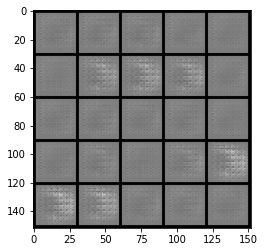

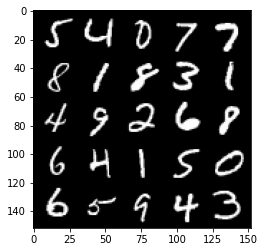

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss: 2.11505594110489, discriminator loss: 0.19240109490603186


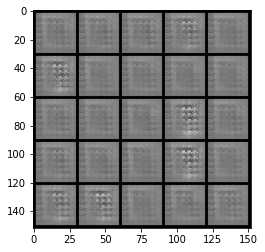

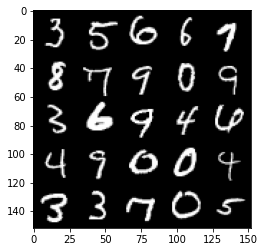

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1500: Generator loss: 2.497527723610403, discriminator loss: 0.21815345420688387


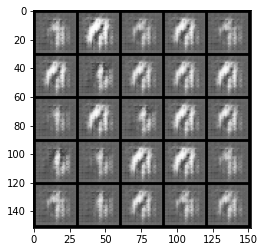

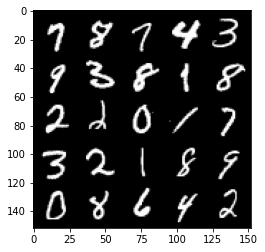

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2000: Generator loss: 1.4305288806557646, discriminator loss: 0.46038783237338066


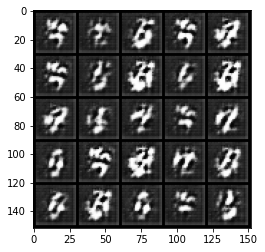

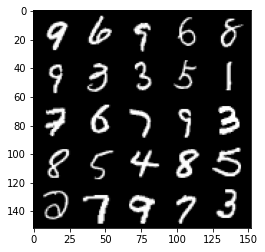

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2500: Generator loss: 1.147843088150025, discriminator loss: 0.5140755534172061


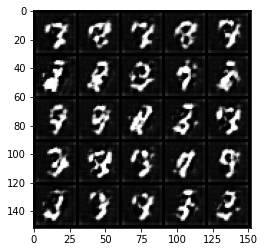

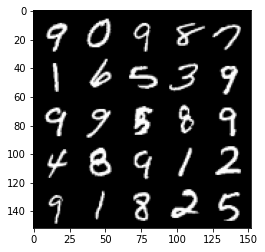

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3000: Generator loss: 0.929472485423088, discriminator loss: 0.5919414343833924


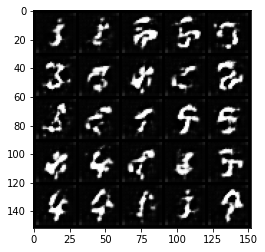

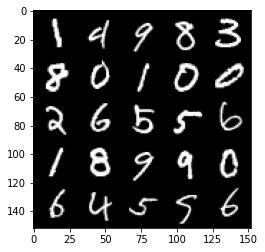

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3500: Generator loss: 0.8476221709847441, discriminator loss: 0.6215662918090822


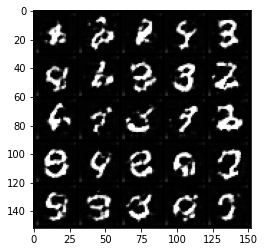

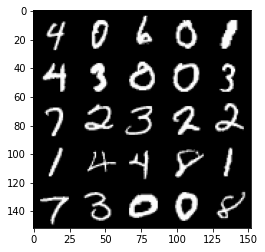

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4000: Generator loss: 0.823920182704925, discriminator loss: 0.6370933834314347


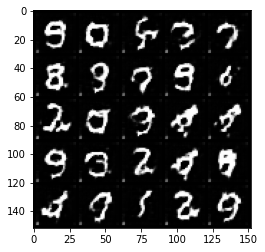

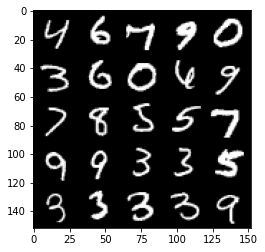

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4500: Generator loss: 0.7972033362388612, discriminator loss: 0.6419850492477424


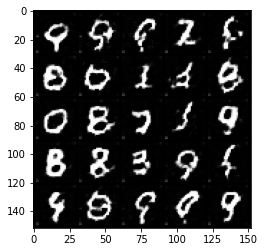

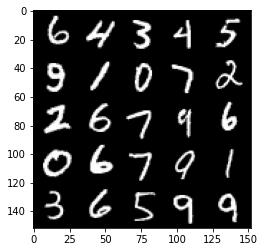

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5000: Generator loss: 0.7928469232916836, discriminator loss: 0.6500576263666156


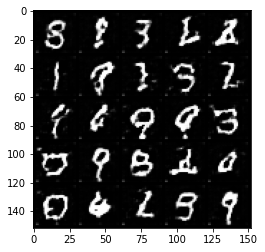

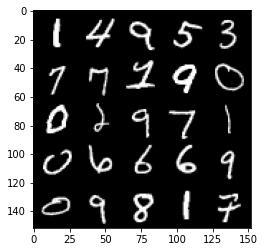

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5500: Generator loss: 0.7860501584410664, discriminator loss: 0.6539192655086519


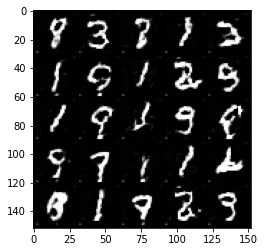

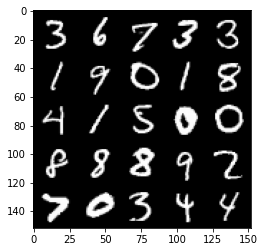

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6000: Generator loss: 0.7837032228708265, discriminator loss: 0.6579779403209685


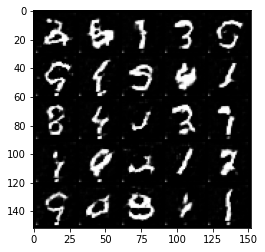

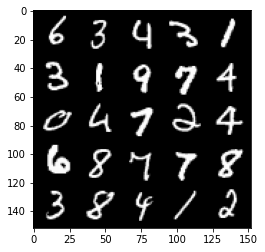

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6500: Generator loss: 0.7738323892354968, discriminator loss: 0.6647052948474885


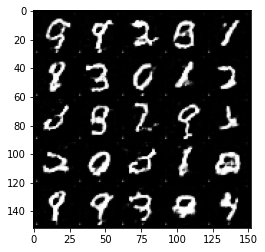

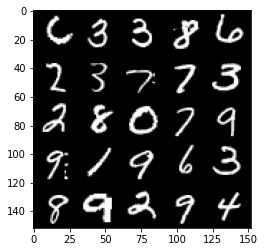

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7000: Generator loss: 0.7677158574461934, discriminator loss: 0.665949648737906


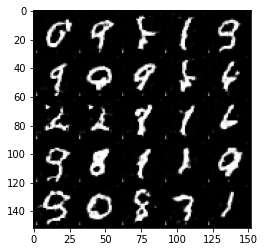

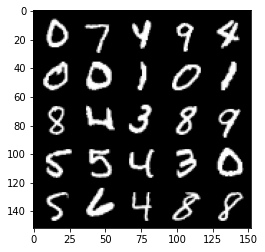

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7500: Generator loss: 0.7676648485660547, discriminator loss: 0.6650642528533934


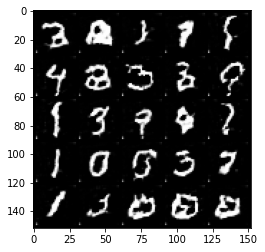

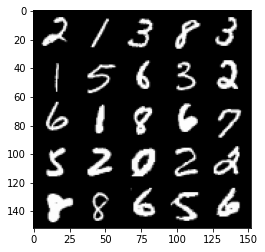

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8000: Generator loss: 0.7677621505260463, discriminator loss: 0.6696842693090432


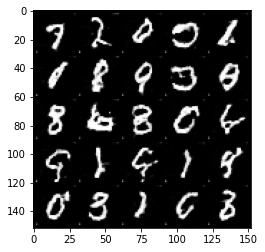

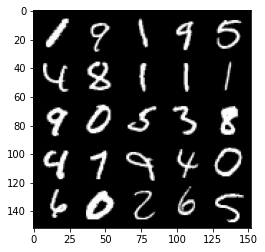

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8500: Generator loss: 0.7567539389133455, discriminator loss: 0.6768152766227723


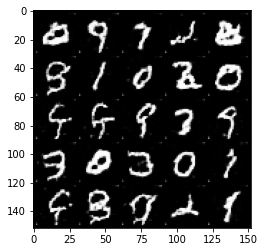

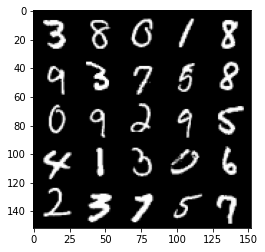

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9000: Generator loss: 0.7433079051971434, discriminator loss: 0.6832461857795714


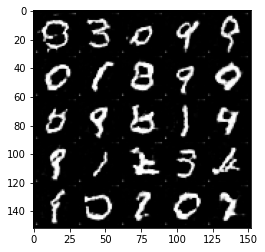

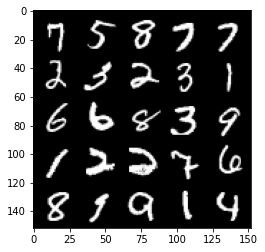

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9500: Generator loss: 0.7386642865538595, discriminator loss: 0.684556215643883


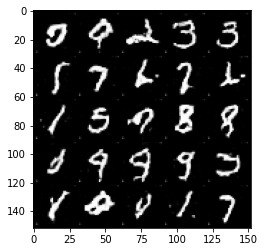

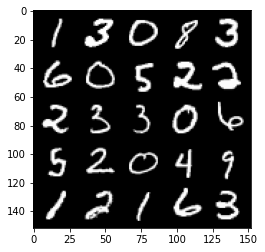

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10000: Generator loss: 0.7335364645123473, discriminator loss: 0.6862764030694956


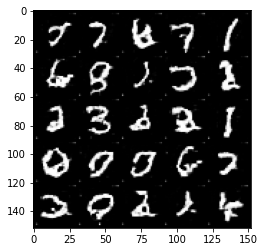

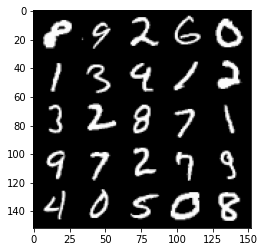

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10500: Generator loss: 0.7317251732945443, discriminator loss: 0.6909217056035993


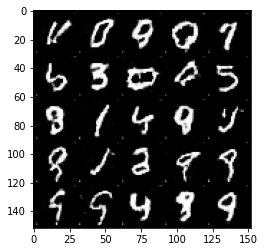

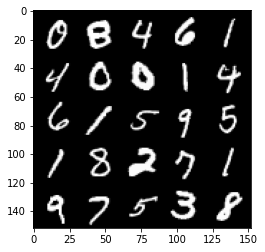

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11000: Generator loss: 0.723766255259514, discriminator loss: 0.6925921877622607


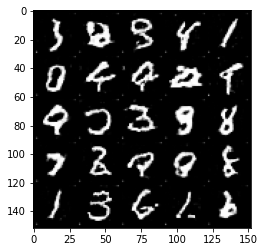

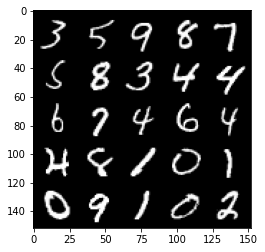

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11500: Generator loss: 0.7180216915607448, discriminator loss: 0.6947667231559754


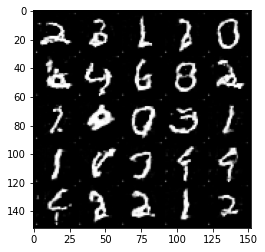

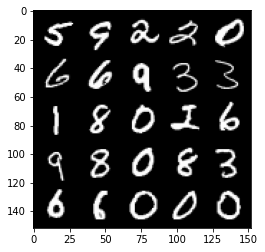

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12000: Generator loss: 0.7179120512008664, discriminator loss: 0.6959058163166049


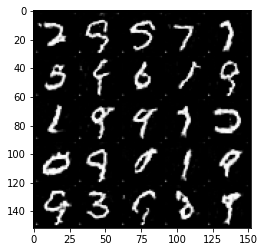

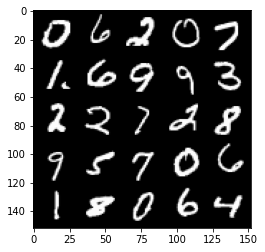

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12500: Generator loss: 0.7193064438700674, discriminator loss: 0.6968303719758987


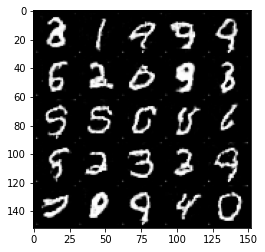

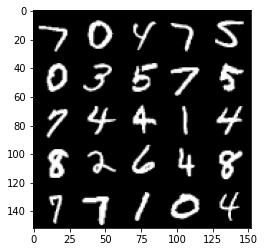

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13000: Generator loss: 0.7164992235302924, discriminator loss: 0.695246436357498


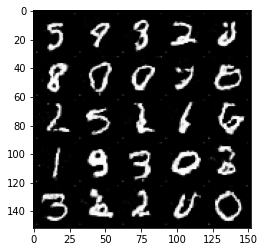

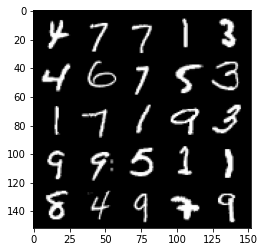

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13500: Generator loss: 0.7189842423200605, discriminator loss: 0.6962754336595537


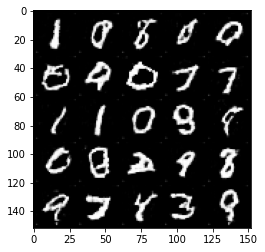

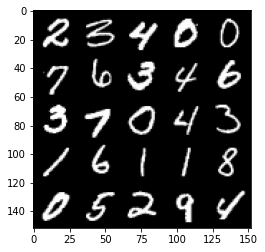

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14000: Generator loss: 0.7137510766983035, discriminator loss: 0.6980388256311418


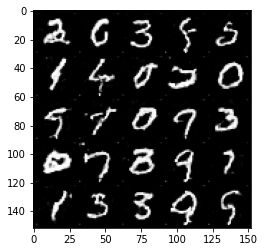

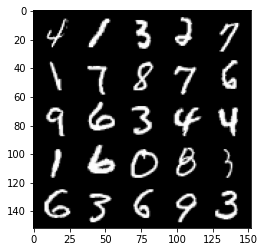

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14500: Generator loss: 0.7152356815338131, discriminator loss: 0.6966486736536021


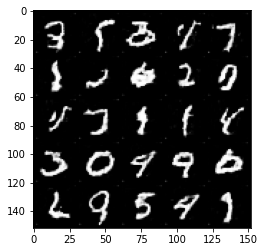

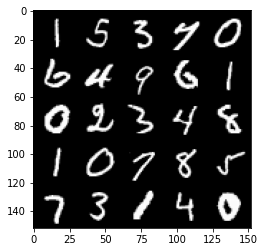

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15000: Generator loss: 0.7130875710248952, discriminator loss: 0.6972939802408216


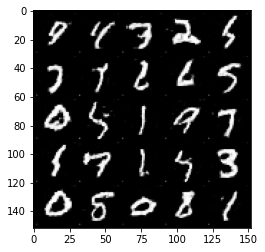

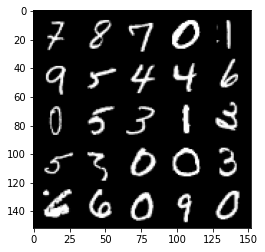

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15500: Generator loss: 0.7116002251505854, discriminator loss: 0.6962652213573455


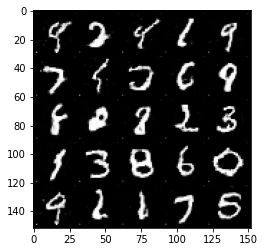

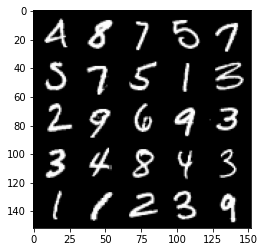

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16000: Generator loss: 0.7095520769357677, discriminator loss: 0.6967977989912035


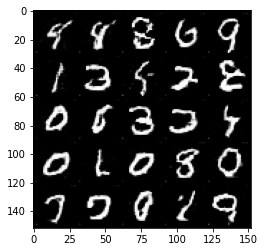

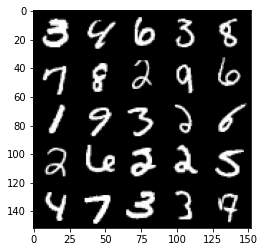

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16500: Generator loss: 0.7073138360381126, discriminator loss: 0.6987185550928114


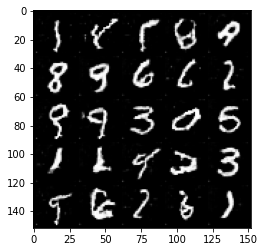

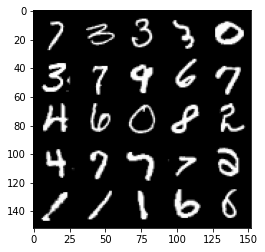

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17000: Generator loss: 0.7091799209117889, discriminator loss: 0.6971312654018408


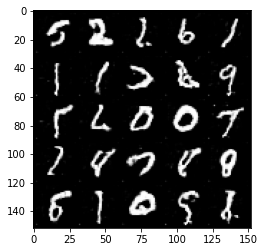

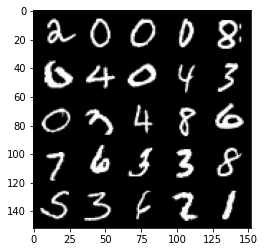

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17500: Generator loss: 0.708032214820385, discriminator loss: 0.6973835369348526


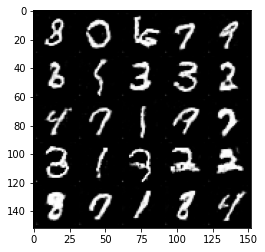

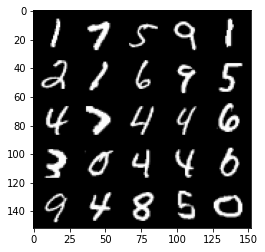

  0%|          | 0/469 [00:00<?, ?it/s]

Step 18000: Generator loss: 0.7066448265314095, discriminator loss: 0.6970226310491552


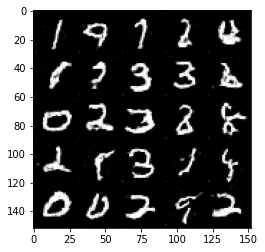

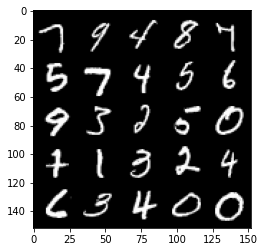

  0%|          | 0/469 [00:00<?, ?it/s]

Step 18500: Generator loss: 0.7072142959833145, discriminator loss: 0.6969398300647732


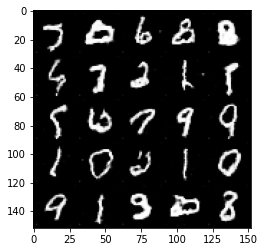

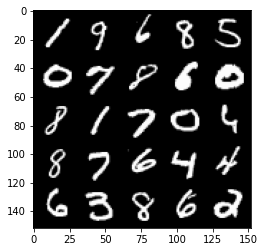

  0%|          | 0/469 [00:00<?, ?it/s]

Step 19000: Generator loss: 0.70490293264389, discriminator loss: 0.6972255923748022


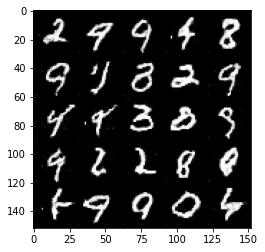

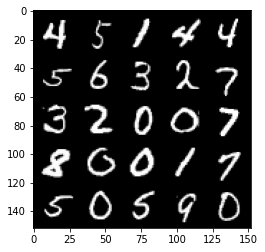

  0%|          | 0/469 [00:00<?, ?it/s]

Step 19500: Generator loss: 0.7029421595335007, discriminator loss: 0.69738557100296


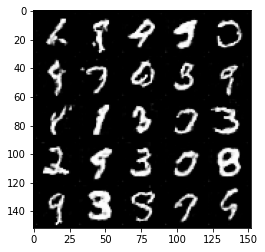

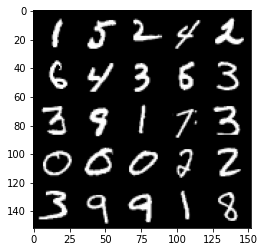

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20000: Generator loss: 0.7050489596128466, discriminator loss: 0.6973876063823702


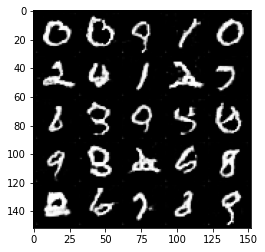

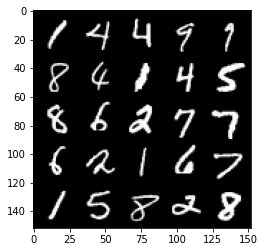

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20500: Generator loss: 0.7027760757207869, discriminator loss: 0.6963648487329491


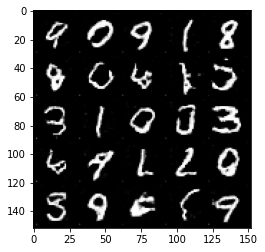

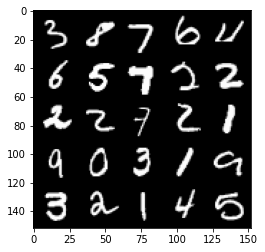

  0%|          | 0/469 [00:00<?, ?it/s]

Step 21000: Generator loss: 0.699754205703735, discriminator loss: 0.6970726876258845


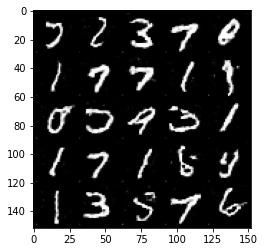

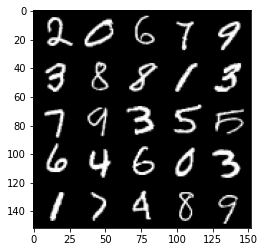

  0%|          | 0/469 [00:00<?, ?it/s]

Step 21500: Generator loss: 0.7009982197284699, discriminator loss: 0.6973850711584103


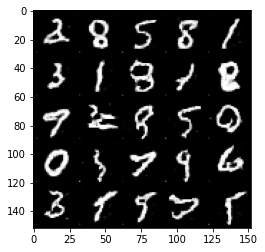

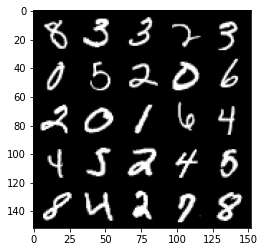

  0%|          | 0/469 [00:00<?, ?it/s]

Step 22000: Generator loss: 0.7003156511783603, discriminator loss: 0.6965281902551643


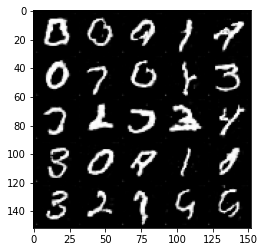

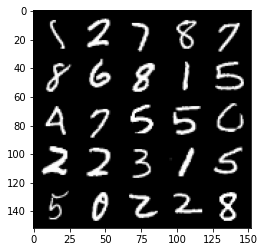

  0%|          | 0/469 [00:00<?, ?it/s]

Step 22500: Generator loss: 0.7036328394412997, discriminator loss: 0.6966680680513387


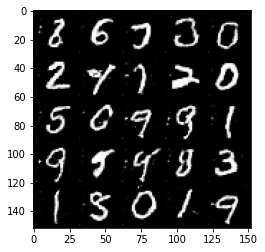

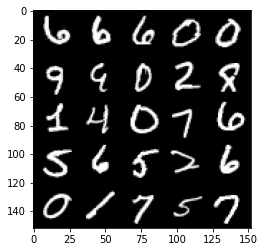

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 23000: Generator loss: 0.7004508028030392, discriminator loss: 0.6962210817337032


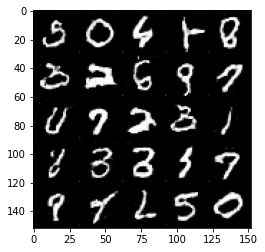

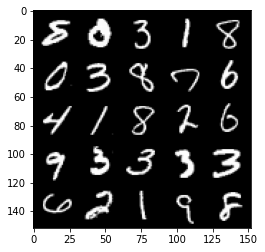

In [32]:
history = pipeline_one.fit(display_step=500, dataloader=dataloader)

In [33]:
def plot_training(history, key_a, key_b):
    fig, ax =  plt.subplots(1,1, dpi=200)
    ax.plot(history[key_a], label=key_a)
    ax.plot(history[key_b], label=key_b)
    ax.set_xlabel('Steps')
    ax.set_ylabel('Binary Crossentropy Loss')
    plt.legend()
    plt.show()

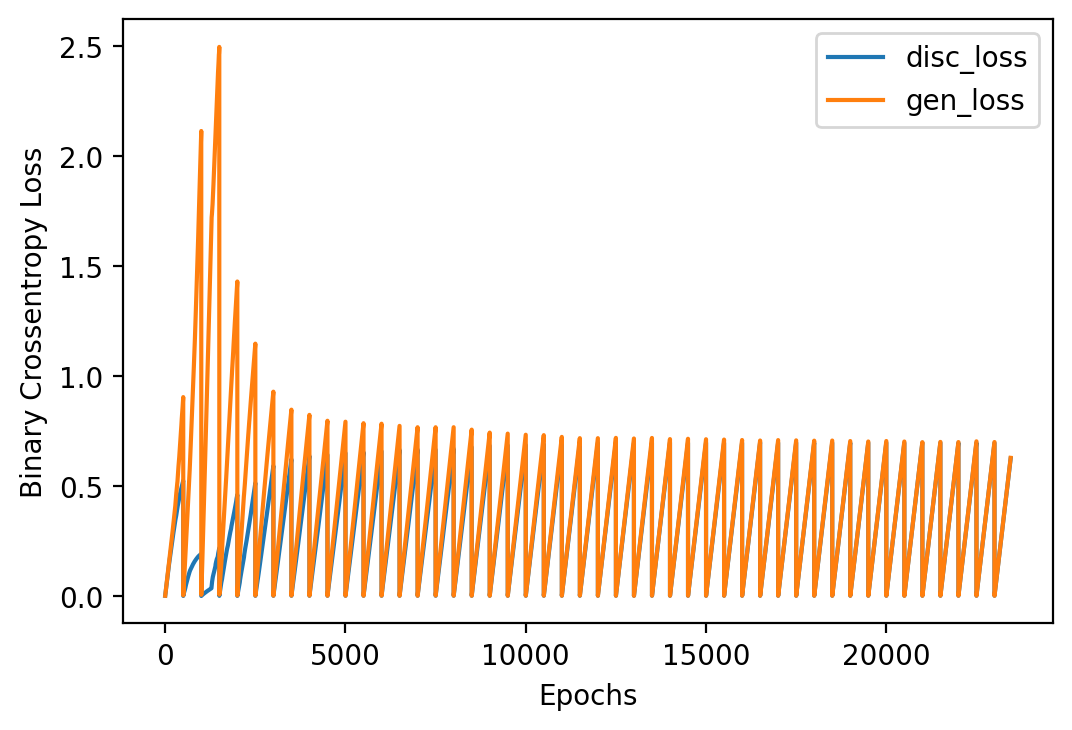

In [34]:
plot_training(history, 'disc_loss', 'gen_loss')